# Simulación Numérica de un Oscilador Armónico Forzado Amortiguado

Este código simula la dinámica de un sistema masa-resorte-amortiguador (MRA) sujeto a diferentes tipos de fuerzas externas. El oscilador está descrito por la ecuación diferencial ordinaria de segundo orden:

$$
m\ddot{x}(t) + c\dot{x}(t) + kx(t) = F(t)
$$

donde:
- $m$ es la masa (kg)
- $c$ es el coeficiente de amortiguamiento (N·s/m)
- $k$ es la rigidez del resorte (N/m)
- $x(t)$ es la posición (m)
- $F(t)$ es la fuerza externa aplicada (N)

## Transformación a Sistema de Primer Orden

Para resolver numéricamente la EDO, se transforma en un sistema de dos ecuaciones de primer orden:

$$
\begin{cases}
\dot{x} = v \\
\dot{v} = \dfrac{F(t) - c v - k x}{m}
\end{cases}
$$

donde $v(t) = \dot{x}(t)$ es la velocidad.

## Tipos de Fuerza Externa Implementados

1. **Fuerza nula** ($F(t) = 0$): Oscilador libre amortiguado
2. **Escalón unitario** ($F(t) = A$ para $t \geq t_0$): Respuesta a entrada constante
3. **Función seno** ($F(t) = A\sin(\omega(t-t_0))$ para $t \geq t_0$): Forzamiento armónico
4. **Función coseno** ($F(t) = A\cos(\omega(t-t_0))$ para $t \geq t_0$): Forzamiento armónico

## Método de Solución Numérica

Se utiliza `solve_ivp` de SciPy con método Runge-Kutta de orden 4-5 (RK45) para integrar el sistema en el intervalo $t \in [t_{\text{inicio}}, t_{\text{final}}]$. La solución se evalúa en `n_puntos` equidistantes.

## Generación de Datos Sintéticos

El código genera un DataFrame de pandas con las columnas:
- `caso`: Identificador del tipo de fuerza aplicada
- `t`: Vector de tiempos discretizados
- `x`: Posición calculada (con ruido gaussiano opcional)
- `v`: Velocidad calculada
- `F`: Fuerza externa aplicada en cada instante

## Parámetros por Defecto

- $m = 1.0$ kg
- $c = 0.6$ N·s/m (sistema subamortiguado)
- $k = 20.0$ N/m
- Condiciones iniciales: $x(0) = 0.0$, $v(0) = 0.0$ (excepto caso libre)
- Tiempo de simulación: $t \in [0, 10]$ segundos
- Resolución temporal: 2000 puntos

El código produce cuatro conjuntos de datos que pueden utilizarse para análisis de vibraciones, identificación de sistemas o aprendizaje automático aplicado a sistemas dinámicos.



In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

# -----------------------------
# Parámetros del sistema
# -----------------------------
m, c, k = 1.0, 0.6, 20.0

# -----------------------------
# Entradas F(t)
# -----------------------------
def F_cero(t, **kwargs):
    return 0.0

def F_escalon(t, A=1.0, t0=1.0, **kwargs):
    return A if t >= t0 else 0.0

def F_seno(t, A=1.0, w=2.0, t0=1.0, **kwargs):
    return 0.0 if t < t0 else A*np.sin(w*(t - t0))

def F_coseno(t, A=1.0, w=2.0, t0=1.0, **kwargs):
    return 0.0 if t < t0 else A*np.cos(w*(t - t0))

# -----------------------------
# Dinámica en 1er orden
# -----------------------------
def mra_forzado(t, X, F_fun, F_kwargs):
    x, v = X
    Ft = F_fun(t, **F_kwargs)
    dx_dt = v
    dv_dt = (Ft - c*v - k*x)/m
    return [dx_dt, dv_dt]

# -----------------------------
# Generador de datos sintéticos
# -----------------------------
def generar_datos_mra(
    nombre="CASO",
    F_fun=F_cero,
    F_kwargs=None,
    t_inicio=0.0,
    t_final=10.0,
    n_puntos=2000,
    x0=0.0,
    v0=0.0,
    sigma_ruido=0.0,     # ruido gaussiano en x(t)
    seed=123
):
                                                            # Evita errores cuando la fuerza no necesita parámetros adicionales.
                                                            # “Si la fuerza no tiene parámetros, igual quiero que la función funcione sin romperse”.
    if F_kwargs is None:
        F_kwargs = {}

    t_eval = np.linspace(t_inicio, t_final, n_puntos)       # eje temporal donde se evalua la solucion (en que instante quiero la solucion)

    sol = solve_ivp(
        fun=lambda t, X: mra_forzado(t, X, F_fun, F_kwargs),
        t_span=(t_inicio, t_final),
        y0=[x0, v0],
        t_eval=t_eval,
        method="RK45",
        rtol=1e-7,
        atol=1e-9
    )

    t = sol.t
    x = sol.y[0]
    v = sol.y[1]
    F = np.array([F_fun(ti, **F_kwargs) for ti in t])

    # Agregar ruido (opcional)
    if sigma_ruido > 0:
        rng = np.random.default_rng(seed)
        x = x + rng.normal(0.0, sigma_ruido, size=x.shape)

    df = pd.DataFrame({
        "caso": nombre,
        "t": t,
        "x": x,
        "v": v,
        "F": F
    })

    return df

# -----------------------------
# Ejemplos de datasets
# -----------------------------
df_libre   = generar_datos_mra(nombre="LIBRE",   F_fun=F_cero,    x0=0.1, v0=0.0, sigma_ruido=0.0)
df_escalon = generar_datos_mra(nombre="ESCALON", F_fun=F_escalon, F_kwargs={"A": 1.0, "t0": 1.0}, x0=0.0, v0=0.0)
df_seno    = generar_datos_mra(nombre="SENO",    F_fun=F_seno,    F_kwargs={"A": 1.0, "w": 2.0, "t0": 1.0}, x0=0.0, v0=0.0)
df_coseno  = generar_datos_mra(nombre="COSENO",  F_fun=F_coseno,  F_kwargs={"A": 1.0, "w": 2.0, "t0": 1.0}, x0=0.0, v0=0.0)

df_todos = pd.concat([df_libre, df_escalon, df_seno, df_coseno], ignore_index=True)

df_todos.tail(40)


,caso,t,x,v,F
7960,COSENO,9.804902,0.015426,0.140485,0.325032
7961,COSENO,9.809905,0.016128,0.140135,0.334477
7962,COSENO,9.814907,0.016828,0.139763,0.343889
7963,COSENO,9.819910,0.017527,0.139369,0.353266
7964,COSENO,9.824912,0.018223,0.138954,0.362608
7965,COSENO,9.829915,0.018917,0.138517,0.371914
7966,COSENO,9.834917,0.019609,0.138058,0.381183
7967,COSENO,9.839920,0.020298,0.137578,0.390413
7968,COSENO,9.844922,0.020985,0.137077,0.399604
7969,COSENO,9.849925,0.021669,0.136554,0.408756


# Visualización de Datos Sintéticos del Oscilador Forzado

Este bloque de código proporciona herramientas para visualizar los resultados de la simulación del sistema masa-resorte-amortiguador (MRA) forzado. La visualización es esencial para comprender la respuesta dinámica del sistema bajo diferentes condiciones de excitación.

## Estructura de los Datos

El DataFrame `df_todos` contiene los datos sintéticos generados previamente, con las siguientes columnas para cada caso simulado:
- **caso**: Identificador del tipo de fuerza aplicada (LIBRE, ESCALON, SENO, COSENO)
- **t**: Vector de tiempos discretizados
- **x**: Posición del sistema en cada instante
- **v**: Velocidad del sistema en cada instante  
- **F**: Fuerza externa aplicada

## Función de Graficación `plot_mra`

La función `plot_mra` genera dos tipos de visualizaciones:

### 1. Panel de Tres Gráficas Individuales
Muestra en una fila:
- **x(t)**: Evolución temporal de la posición del oscilador
- **v(t)**: Evolución temporal de la velocidad del oscilador  
- **F(t)**: Perfil temporal de la fuerza externa aplicada

### 2. Gráfica Combinada
Superpone en un solo gráfico:
- La posición $x(t)$ y velocidad $v(t)$ para comparar su evolución temporal
- Una línea vertical opcional que marca un evento específico en el tiempo

## Parámetros de la Función

```python
plot_mra(df, caso, t_evento=None)
```

- `df`: DataFrame que contiene los datos de todos los casos
- `caso`: Cadena que especifica qué caso visualizar (ej: "COSENO", "LIBRE", etc.)
- `t_evento`: Tiempo opcional para marcar un evento (ej: inicio de la fuerza externa)

## Análisis de la Respuesta del Sistema

Para cada tipo de fuerza externa, se pueden observar diferentes comportamientos:

### Caso Libre ($F(t) = 0$)
- **x(t)**: Exponencial amortiguada con oscilaciones
- **v(t)**: Derivada de la posición, muestra el mismo patrón amortiguado
- Dominado por la frecuencia natural amortiguada: $\omega_d = \sqrt{\frac{k}{m} - \left(\frac{c}{2m}\right)^2}$

### Caso con Fuerza Escalón
- Respuesta transitoria seguida de estado estacionario
- El sistema alcanza una posición de equilibrio diferente

### Caso con Fuerza Armónica (seno/coseno)
- Respuesta en estado estacionario a la frecuencia de excitación $\omega$
- Posible resonancia si $\omega \approx \omega_n = \sqrt{k/m}$
- Amplitud máxima dada por: $A_{\text{max}} = \frac{F_0/m}{\sqrt{(\omega_n^2 - \omega^2)^2 + (2\zeta\omega_n\omega)^2}}$

## Interpretación Física

1. **Fase entre x(t) y F(t)**: En régimen armónico, hay un desfase que depende de la relación entre frecuencia de excitación y frecuencia natural
2. **Efecto del amortiguamiento**: Reduce la amplitud de oscilación y acelera la disipación de energía
3. **Respuesta transitoria vs estacionaria**: La solución completa es suma de la respuesta homogénea (transitoria) y particular (estacionaria)

Esta visualización permite validar la solución numérica, comprender la física del sistema y preparar los datos para aplicaciones de identificación de sistemas o aprendizaje automático.

Casos disponibles: ['LIBRE' 'ESCALON' 'SENO' 'COSENO']


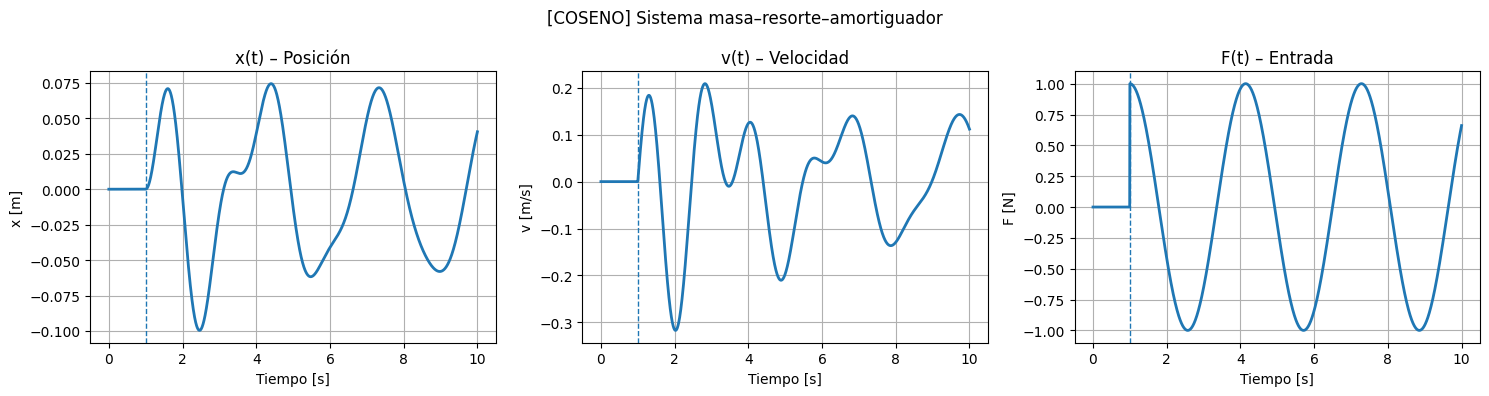

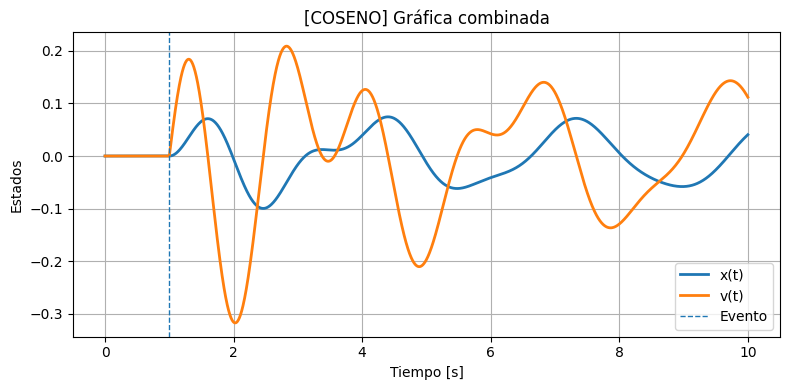

In [ ]:
# ============================================================
# [B-GRAF-SIMPLE] VISUALIZACIÓN DE DATOS SINTÉTICOS (df_todos)
# ============================================================

import matplotlib.pyplot as plt

# -----------------------------
# (1) Casos disponibles
# -----------------------------
casos = df_todos["caso"].unique()
print("Casos disponibles:", casos)


# -----------------------------
# (2) Función única de graficación
# -----------------------------
def plot_mra(df, caso, t_evento=None):
    d = df[df["caso"] == caso].sort_values("t")
    if d.empty:
        raise ValueError(f"Caso '{caso}' no encontrado.")

    t = d["t"].to_numpy()
    x = d["x"].to_numpy()
    v = d["v"].to_numpy()
    F = d["F"].to_numpy()

    fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

    ax[0].plot(t, x, lw=2)
    ax[0].set_title("x(t) – Posición")
    ax[0].set_xlabel("Tiempo [s]")
    ax[0].set_ylabel("x [m]")
    ax[0].grid(True)

    ax[1].plot(t, v, lw=2)
    ax[1].set_title("v(t) – Velocidad")
    ax[1].set_xlabel("Tiempo [s]")
    ax[1].set_ylabel("v [m/s]")
    ax[1].grid(True)

    ax[2].plot(t, F, lw=2)
    ax[2].set_title("F(t) – Entrada")
    ax[2].set_xlabel("Tiempo [s]")
    ax[2].set_ylabel("F [N]")
    ax[2].grid(True)

    if t_evento is not None and (t.min() <= t_evento <= t.max()):
        for a in ax:
            a.axvline(t_evento, ls="--", lw=1)

    plt.suptitle(f"[{caso}] Sistema masa–resorte–amortiguador", fontsize=12)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(t, x, label="x(t)", lw=2)
    plt.plot(t, v, label="v(t)", lw=2)
    if t_evento is not None and (t.min() <= t_evento <= t.max()):
        plt.axvline(t_evento, ls="--", lw=1, label="Evento")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Estados")
    plt.title(f"[{caso}] Gráfica combinada")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



# -----------------------------
# (3) Uso
# -----------------------------
plot_mra(df_todos, caso="COSENO", t_evento=1.0)


$\hat{x}(t)$

[INFO] Casos disponibles: ['COSENO', 'ESCALON', 'LIBRE', 'SENO']


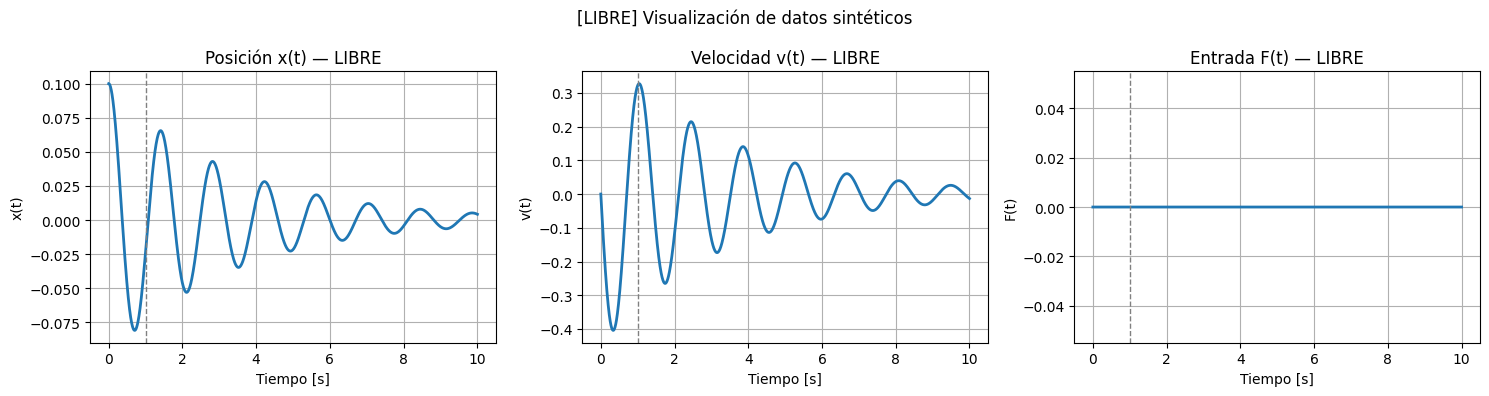

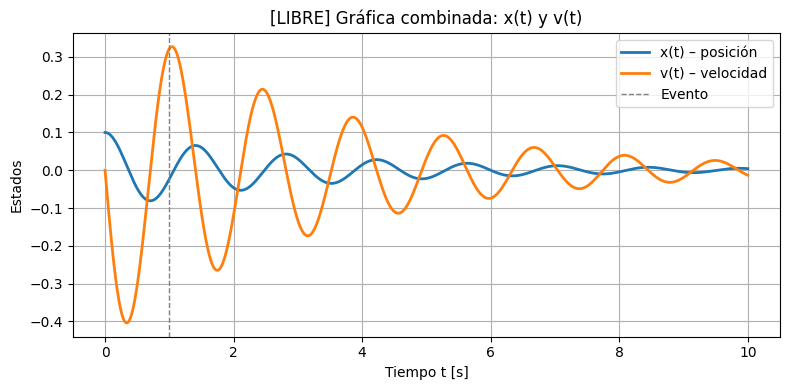

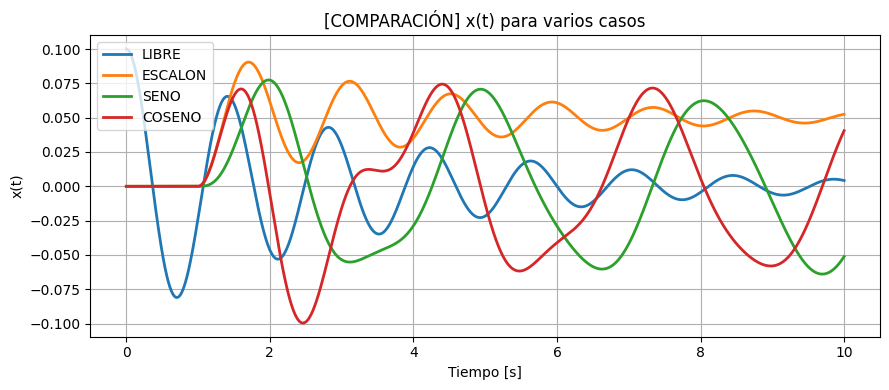

In [ ]:
# ============================================================
# [B-GRAF] VISUALIZACIÓN DINÁMICA DE LOS DATOS SINTÉTICOS (df_todos)
# ------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# (0) Verificar que df_todos existe y tiene lo necesario
# -----------------------------
required_cols = {"caso", "t", "x", "v", "F"}
if "df_todos" not in globals():
    raise NameError("No existe df_todos. Primero genera df_todos con el código anterior.")
if not required_cols.issubset(df_todos.columns):
    raise ValueError(f"df_todos debe contener las columnas {required_cols}. Columnas actuales: {df_todos.columns.tolist()}")

casos_disponibles = sorted(df_todos["caso"].unique().tolist())
print("[INFO] Casos disponibles:", casos_disponibles)


# -----------------------------
# (1) Función principal: graficar un caso
# -----------------------------
def graficar_caso(df, caso, mostrar_3_en_linea=True, mostrar_combinada=True, marcar_evento=None):


    data = df[df["caso"] == caso].sort_values("t")
    if data.empty:
        raise ValueError(f"No hay datos para el caso '{caso}'. Casos disponibles: {sorted(df['caso'].unique().tolist())}")

    t = data["t"].to_numpy()
    x = data["x"].to_numpy()
    v = data["v"].to_numpy()
    F = data["F"].to_numpy()

    # ---- (A) 3 en línea ----
    if mostrar_3_en_linea:
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        axes[0].plot(t, x, linewidth=2)
        axes[0].set_title(f"Posición x(t) — {caso}")
        axes[0].set_xlabel("Tiempo [s]")
        axes[0].set_ylabel("x(t)")
        axes[0].grid(True)

        axes[1].plot(t, v, linewidth=2)
        axes[1].set_title(f"Velocidad v(t) — {caso}")
        axes[1].set_xlabel("Tiempo [s]")
        axes[1].set_ylabel("v(t)")
        axes[1].grid(True)

        axes[2].plot(t, F, linewidth=2)
        axes[2].set_title(f"Entrada F(t) — {caso}")
        axes[2].set_xlabel("Tiempo [s]")
        axes[2].set_ylabel("F(t)")
        axes[2].grid(True)

        if marcar_evento is not None:
            for ax in axes:
                ax.axvline(marcar_evento, color="gray", linestyle="--", linewidth=1)

        plt.suptitle(f"[{caso}] Visualización de datos sintéticos", fontsize=12)
        plt.tight_layout()
        plt.show()

    # ---- (B) combinada x(t) y v(t) ----
    if mostrar_combinada:
        plt.figure(figsize=(8, 4))
        plt.plot(t, x, label="x(t) – posición", linewidth=2)
        plt.plot(t, v, label="v(t) – velocidad", linewidth=2)

        if marcar_evento is not None:
            plt.axvline(marcar_evento, color="gray", linestyle="--", linewidth=1, label="Evento")

        plt.xlabel("Tiempo t [s]")
        plt.ylabel("Estados")
        plt.title(f"[{caso}] Gráfica combinada: x(t) y v(t)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()


# -----------------------------
# (2) Uso rápido (elige un caso)
# -----------------------------
# Cambia el nombre del caso por cualquiera de los mostrados en casos_disponibles.
# Ejemplo típico: en ESCALON/SENO/COSENO el evento es t0=1.0 (si lo generaste así)
caso_a_ver = casos_disponibles[2]  # por defecto el primero__________________________________________
graficar_caso(df_todos, caso=caso_a_ver, marcar_evento=1.0)


# -----------------------------
# (3) Comparación opcional: varios casos en una sola figura (x(t))
# -----------------------------
def comparar_casos_x(df, lista_casos):
    """
    Compara x(t) de varios casos en una sola gráfica.
    """
    plt.figure(figsize=(9, 4))
    for caso in lista_casos:
        data = df[df["caso"] == caso].sort_values("t")
        if data.empty:
            continue
        plt.plot(data["t"], data["x"], linewidth=2, label=caso)

    plt.xlabel("Tiempo [s]")
    plt.ylabel("x(t)")
    plt.title("[COMPARACIÓN] x(t) para varios casos")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Ejemplo: comparar los 4 casos si existen
comparar_lista = [c for c in ["LIBRE", "ESCALON", "SENO", "COSENO"] if c in casos_disponibles]
if len(comparar_lista) >= 2:
    comparar_casos_x(df_todos, comparar_lista)


In [ ]:
!pip -q install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.5 MB/s eta 0:00:00


Compiling model...
'compile' took 0.016635 s

Training model...



Cause: could not parse the source code of <function <lambda> at 0x78a426d6bf60>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x78a426d6bf60>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Step      Train loss                                  Test loss                                   Test metric
0         [1.47e+02, 0.00e+00, 5.49e-02, 0.00e+00]    [1.47e+02, 0.00e+00, 5.49e-02, 0.00e+00]    []  
200       [9.72e-02, 9.72e-04, 1.38e-02, 0.00e+00]    [9.72e-02, 9.72e-04, 1.38e-02, 0.00e+00]    []  
400       [7.97e-02, 1.05e-03, 1.16e-02, 0.00e+00]    [7.97e-02, 1.05e-03, 1.16e-02, 0.00e+00]    []  
600       [7.49e-02, 7.91e-04, 8.60e-03, 0.00e+00]    [7.49e-02, 7.91e-04, 8.60e-03, 0.00e+00]   

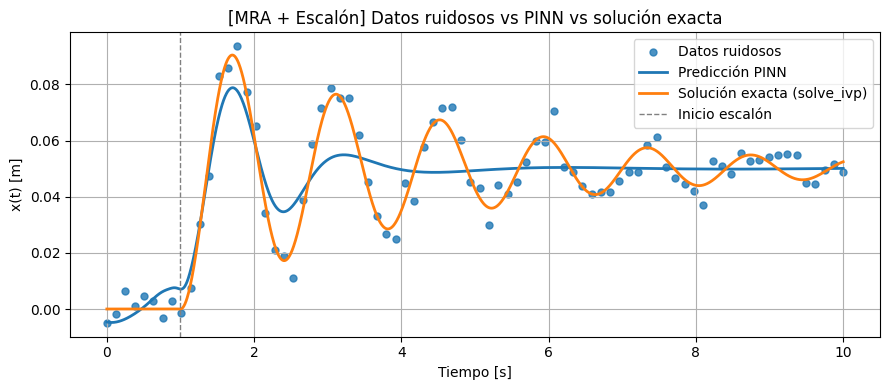

Backend DeepXDE: tensorflow
Últimas pérdidas: [0.00902416 0.00021558 0.00014632 0.        ]


In [ ]:
# ============================================================
# PINN (DeepXDE) — Sistema Masa–Resorte–Amortiguador (MRA)
# Caso: Entrada Escalón
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import deepxde as dde
import tensorflow as tf  # (tu backend actual)

# -----------------------------
# [B1] Configuración general
# -----------------------------
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Parámetros físicos
m, c, k = 1.0, 0.6, 20.0

# Condiciones iniciales
x0, v0 = 0.0, 0.0

# Tiempo
t_inicio, t_final = 0.0, 10.0
n_eval = 2000
t_eval = np.linspace(t_inicio, t_final, n_eval)

# Entrada escalón
A_escalon, t0_escalon = 1.0, 1.0

# Datos ruidosos
n_datos = 80
sigma_ruido = 0.005

# PINN sampling
num_fisica = 400
num_boundary = 20

# Loss weights: [PDE, IC_pos, IC_vel, DATA]
loss_weights = [5.0, 10.0, 10.0, 0.0]


# -----------------------------
# [B2] Entrada F(t) (NumPy y TF)
# -----------------------------
def F_escalon_numpy(t: float) -> float:
    return A_escalon if t >= t0_escalon else 0.0

def F_escalon_tf(t):
    t0 = tf.constant(t0_escalon, dtype=t.dtype)
    A  = tf.constant(A_escalon,  dtype=t.dtype)
    return tf.where(t >= t0, A * tf.ones_like(t), tf.zeros_like(t))


# -----------------------------
# [B3] Ground truth con solve_ivp
# -----------------------------
def dinamica_forzada(t, X):
    x, v = X
    Ft = F_escalon_numpy(t)
    return [v, (Ft - c*v - k*x) / m]

sol_true = solve_ivp(
    fun=dinamica_forzada,
    t_span=(t_inicio, t_final),
    y0=[x0, v0],
    t_eval=t_eval,
    method="RK45",
    rtol=1e-8,
    atol=1e-10
)
x_true = sol_true.y[0]


# -----------------------------
# [B4] Crear datos ruidosos
# -----------------------------
t_datos = np.linspace(t_inicio, t_final, n_datos)
x_true_datos = np.interp(t_datos, t_eval, x_true)

rng = np.random.default_rng(SEED)
x_ruidoso = x_true_datos + rng.normal(0.0, sigma_ruido, size=x_true_datos.shape)

t_datos_dd = t_datos.reshape(-1, 1)
x_ruidoso_dd = x_ruidoso.reshape(-1, 1)
# reshape(-1,1) porque DeepXDE espera entradas 2D tipo (N,1), no vectores (N,).

# -----------------------------
# [B5] Definir PINN: PDE + IC + datos
# -----------------------------
geom = dde.geometry.TimeDomain(t_inicio, t_final)

def pde_mra(t, x):
    x_t  = dde.grad.jacobian(x, t, i=0, j=0)
    x_tt = dde.grad.hessian(x, t, i=0, j=0)
    return m * x_tt + c * x_t + k * x - F_escalon_tf(t)

def on_initial(t, on_initial):
    return on_initial

ic_pos = dde.icbc.IC(geom, lambda t: x0, on_initial)

def vel_operator(t, x, _):
    return dde.grad.jacobian(x, t, i=0, j=0)

ic_vel = dde.icbc.OperatorBC(geom, lambda t, x, _: vel_operator(t, x, _) - v0, on_initial)

obs_x = dde.icbc.PointSetBC(t_datos_dd, x_ruidoso_dd, component=0)

data = dde.data.TimePDE(
    geom, pde_mra, [ic_pos, ic_vel, obs_x],
    num_domain=num_fisica, num_boundary=num_boundary
)

net = dde.nn.FNN([1, 64, 64, 64, 1], "tanh", "Glorot normal")
model = dde.Model(data, net)


# -----------------------------
# [B6] Entrenar
# -----------------------------
model.compile("adam", lr=1e-3, loss_weights=loss_weights)
losshistory, train_state = model.train(iterations=8000, display_every=200)

model.compile("L-BFGS", loss_weights=loss_weights)
losshistory, train_state = model.train()


# -----------------------------
# [B7] Evaluar y graficar
# -----------------------------
x_pinn = model.predict(t_eval.reshape(-1, 1)).reshape(-1)

plt.figure(figsize=(9, 4))
plt.scatter(t_datos, x_ruidoso, s=25, alpha=0.8, label="Datos ruidosos")
plt.plot(t_eval, x_pinn, lw=2, label="Predicción PINN")
plt.plot(t_eval, x_true, lw=2, label="Solución exacta (solve_ivp)")
plt.axvline(t0_escalon, color="gray", ls="--", lw=1, label="Inicio escalón")
plt.xlabel("Tiempo [s]")
plt.ylabel("x(t) [m]")
plt.title("[MRA + Escalón] Datos ruidosos vs PINN vs solución exacta")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Backend DeepXDE:", dde.backend.backend_name)
print("Últimas pérdidas:", losshistory.loss_train[-1])


Compiling model...
'compile' took 0.012274 s

Training model...



Cause: could not parse the source code of <function <lambda> at 0x78a4278be660>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x78a4278be660>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Step      Train loss                                  Test loss                                   Test metric
0         [2.34e+01, 0.00e+00, 5.49e-02, 3.74e+00]    [2.34e+01, 0.00e+00, 5.49e-02, 3.74e+00]    []  
200       [7.01e-02, 1.99e-04, 7.75e-03, 1.56e-02]    [7.01e-02, 1.99e-04, 7.75e-03, 1.56e-02]    []  
400       [6.21e-02, 3.86e-04, 6.94e-03, 1.42e-02]    [6.21e-02, 3.86e-04, 6.94e-03, 1.42e-02]    []  
600       [5.96e-02, 3.20e-04, 5.23e-03, 1.37e-02]    [5.96e-02, 3.20e-04, 5.23e-03, 1.37e-02]   

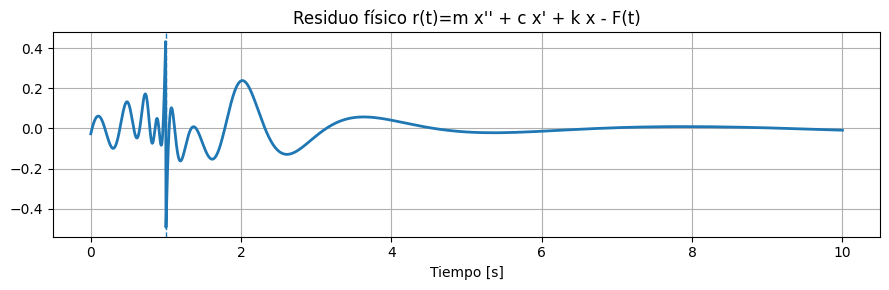

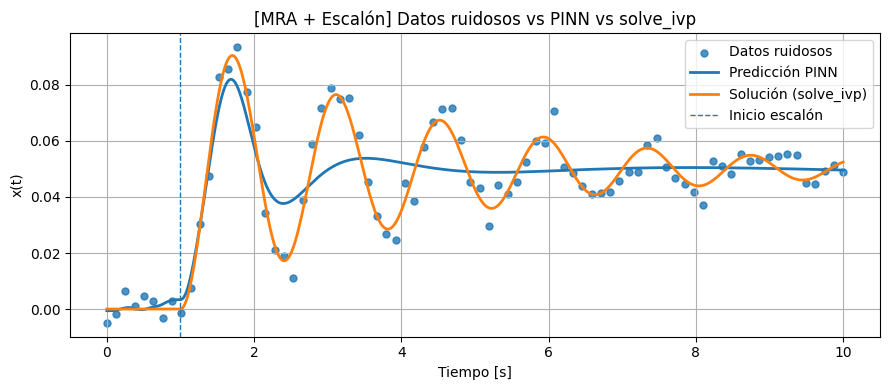

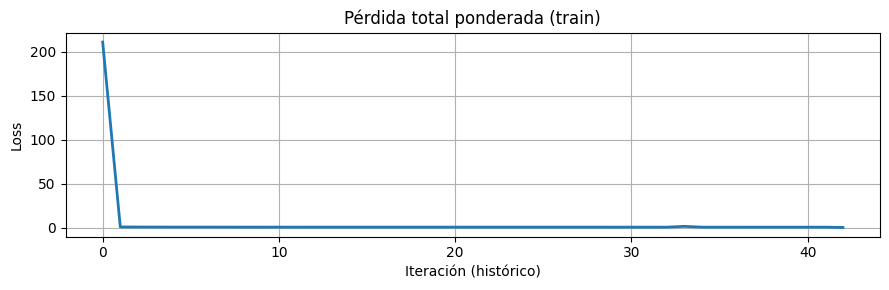

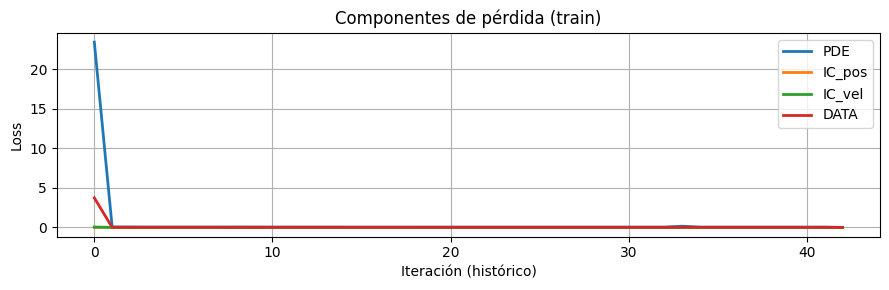

Backend DeepXDE: tensorflow
Últimas pérdidas (train): [7.8154821e-03 3.3759129e-06 3.4939947e-06 6.6739195e-03]


In [ ]:
# ============================================================
# PINN (DeepXDE) — Sistema Masa–Resorte–Amortiguador (MRA)
# Caso: Entrada Escalón
# Ajustado con mejoras: IC más clara, métricas, residuo físico,
# backend print robusto, y (opcional) escalón suave + anchors cerca de t0
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import deepxde as dde
import tensorflow as tf

# -----------------------------
# [B1] Configuración general
# -----------------------------
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Parámetros físicos
m, c, k = 1.0, 0.6, 20.0

# Condiciones iniciales
x0, v0 = 0.0, 0.0

# Tiempo
t_inicio, t_final = 0.0, 10.0
n_eval = 2000
t_eval = np.linspace(t_inicio, t_final, n_eval)

# Entrada escalón
A_escalon, t0_escalon = 1.0, 1.0

# Datos ruidosos (observaciones)
n_datos = 80
sigma_ruido = 0.005

# PINN sampling
num_fisica = 400
num_boundary = 20

# Loss weights: [PDE, IC_pos, IC_vel, DATA]
loss_weights = [1.0, 10.0, 10.0, 50.0]

# Opcional: escalón suave (ayuda cerca de la discontinuidad)
USAR_ESCALON_SUAVE = False
BETA_SUAVIZADO = 50.0  # mayor = más parecido a escalón ideal

# Opcional: anchors (más puntos físicos cerca de t0 para estabilizar)
USAR_ANCHORS = True
ANCHOR_WINDOW = 0.15     # ventana alrededor de t0 (s)
N_ANCHORS = 120          # cantidad de anchors

# -----------------------------
# [B2] Entrada F(t): NumPy y TF
# -----------------------------
def F_escalon_numpy(t: float) -> float:
    return A_escalon if t >= t0_escalon else 0.0

def F_escalon_tf_duro(t):
    """Escalón ideal (discontinuo) en TF."""
    t0 = tf.constant(t0_escalon, dtype=t.dtype)
    A  = tf.constant(A_escalon,  dtype=t.dtype)
    return tf.where(t >= t0, A * tf.ones_like(t), tf.zeros_like(t))

def F_escalon_tf_suave(t, beta=BETA_SUAVIZADO):
    """Aproximación suave: A * sigmoid(beta*(t-t0))."""
    t0 = tf.constant(t0_escalon, dtype=t.dtype)
    A  = tf.constant(A_escalon,  dtype=t.dtype)
    beta_tf = tf.constant(beta, dtype=t.dtype)
    return A * tf.sigmoid(beta_tf * (t - t0))

def F_escalon_tf(t):
    return F_escalon_tf_suave(t) if USAR_ESCALON_SUAVE else F_escalon_tf_duro(t)

# -----------------------------
# [B3] Ground truth con solve_ivp
# -----------------------------
def dinamica_forzada(t, X):
    x, v = X
    Ft = F_escalon_numpy(t)
    return [v, (Ft - c*v - k*x) / m]

sol_true = solve_ivp(
    fun=dinamica_forzada,
    t_span=(t_inicio, t_final),
    y0=[x0, v0],
    t_eval=t_eval,
    method="RK45",
    rtol=1e-8,
    atol=1e-10
)
x_true = sol_true.y[0]

# -----------------------------
# [B4] Crear datos ruidosos (observaciones)
# -----------------------------
t_datos = np.linspace(t_inicio, t_final, n_datos)
x_true_datos = np.interp(t_datos, t_eval, x_true)

rng = np.random.default_rng(SEED)
x_ruidoso = x_true_datos + rng.normal(0.0, sigma_ruido, size=x_true_datos.shape)

t_datos_dd = t_datos.reshape(-1, 1)      # DeepXDE espera (N,1)
x_ruidoso_dd = x_ruidoso.reshape(-1, 1)  # DeepXDE espera (N,1)

# -----------------------------
# [B5] Definir PINN: PDE + IC + datos
# -----------------------------
geom = dde.geometry.TimeDomain(t_inicio, t_final)

# (a) PDE: m x'' + c x' + k x = F(t)
def pde_mra(t, x):
    x_t  = dde.grad.jacobian(x, t, i=0, j=0)
    x_tt = dde.grad.hessian(x, t, i=0, j=0)
    return m * x_tt + c * x_t + k * x - F_escalon_tf(t)

# (b) Indicador inicial (más legible)
def on_initial(t, is_initial):
    return is_initial

# IC posición: x(0)=x0
ic_pos = dde.icbc.IC(geom, lambda t: x0, on_initial)

# IC velocidad: x'(0)=v0
def vel_bc(t, x, _):
    x_t = dde.grad.jacobian(x, t, i=0, j=0)
    return x_t - v0

ic_vel = dde.icbc.OperatorBC(geom, vel_bc, on_initial)

# Observaciones: x(t_i) ≈ x_ruidoso
obs_x = dde.icbc.PointSetBC(t_datos_dd, x_ruidoso_dd, component=0)

# (c) Anchors cerca de t0 (opcional)
anchors = None
if USAR_ANCHORS:
    t_left = max(t_inicio, t0_escalon - ANCHOR_WINDOW)
    t_right = min(t_final, t0_escalon + ANCHOR_WINDOW)
    anchors = np.linspace(t_left, t_right, N_ANCHORS).reshape(-1, 1)

data = dde.data.TimePDE(
    geom,
    pde_mra,
    [ic_pos, ic_vel, obs_x],
    num_domain=num_fisica,
    num_boundary=num_boundary,
    anchors=anchors
)

net = dde.nn.FNN([1, 64, 64, 64, 1], "tanh", "Glorot normal")
model = dde.Model(data, net)

# -----------------------------
# [B6] Entrenar (Adam -> L-BFGS)
# -----------------------------
model.compile("adam", lr=5e-4, loss_weights=loss_weights)  # lr un poco menor ayuda con escalón
losshistory, train_state = model.train(iterations=8000, display_every=200)

model.compile("L-BFGS", loss_weights=loss_weights)
losshistory, train_state = model.train()

# -----------------------------
# [B7] Predicción y métricas
# -----------------------------
x_pinn = model.predict(t_eval.reshape(-1, 1)).reshape(-1)

# Métricas vs solución "exacta" numérica
y_true = x_true
y_pred = x_pinn

mse = np.mean((y_pred - y_true) ** 2)
mae = np.mean(np.abs(y_pred - y_true))
r2 = 1.0 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))

print(f"MAE={mae:.4e} | MSE={mse:.4e} | R2={r2:.6f}")

# -----------------------------
# [B8] Residuo físico r(t) = m x'' + c x' + k x - F(t)
# -----------------------------
r = model.predict(t_eval.reshape(-1, 1), operator=pde_mra).reshape(-1)

plt.figure(figsize=(9, 3))
plt.plot(t_eval, r, lw=2)
plt.axvline(t0_escalon, ls="--", lw=1)
plt.title("Residuo físico r(t)=m x'' + c x' + k x - F(t)")
plt.xlabel("Tiempo [s]")
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# [B9] Gráfica principal: datos vs PINN vs solve_ivp
# -----------------------------
plt.figure(figsize=(9, 4))
plt.scatter(t_datos, x_ruidoso, s=25, alpha=0.8, label="Datos ruidosos")
plt.plot(t_eval, x_pinn, lw=2, label="Predicción PINN")
plt.plot(t_eval, x_true, lw=2, label="Solución (solve_ivp)")
plt.axvline(t0_escalon, ls="--", lw=1, label="Inicio escalón")
plt.xlabel("Tiempo [s]")
plt.ylabel("x(t)")
plt.title("[MRA + Escalón] Datos ruidosos vs PINN vs solve_ivp")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# [B10] Curvas de pérdida (total y por componente)
# -----------------------------
# DeepXDE guarda loss_train como lista por iteración: [PDE, IC_pos, IC_vel, DATA] (en ese orden)
loss_train = np.array(losshistory.loss_train)  # shape: (iters, n_terms)

# Total ponderado (aprox): suma de componentes * pesos
# Nota: en L-BFGS, DeepXDE continúa registrando, así que esto cubre todo el historial.
w = np.array(loss_weights, dtype=float)
total_weighted = (loss_train * w.reshape(1, -1)).sum(axis=1)

plt.figure(figsize=(9, 3))
plt.plot(total_weighted, lw=2)
plt.title("Pérdida total ponderada (train)")
plt.xlabel("Iteración (histórico)")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

labels = ["PDE", "IC_pos", "IC_vel", "DATA"]
plt.figure(figsize=(9, 3))
for i in range(loss_train.shape[1]):
    plt.plot(loss_train[:, i], lw=2, label=labels[i])
plt.title("Componentes de pérdida (train)")
plt.xlabel("Iteración (histórico)")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# [B11] Backend (print robusto)
# -----------------------------
try:
    print("Backend DeepXDE:", dde.backend.backend_name())
except Exception:
    # fallback por si la versión expone backend_name como atributo
    print("Backend DeepXDE:", getattr(dde.backend, "backend_name", "desconocido"))

print("Últimas pérdidas (train):", losshistory.loss_train[-1])
